In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

In [6]:
data = pd.read_csv("359_features.csv")
X = data.drop(columns=["Label"])
y = data["Label"]

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt

def create_autoencoder(input_dim, latent_dim=16):
    input_layer = Input(shape=(input_dim,), name='Input')
    encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5), name='Encoding')(input_layer)
    latent = Dense(latent_dim, activation='relu', name='Latent')(encoded)
    decoded = Dense(100, activation='relu', name='Decoding')(latent)
    output_layer = Dense(input_dim, activation='linear', name='Output')(decoded)

    autoencoder = Model(input_layer, output_layer)
    return autoencoder

def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return (loss.numpy() < threshold).astype(int)

def print_stats(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 score = {f1}")
    return accuracy, precision, recall, f1

# Load your data
data = pd.read_csv("New_binary_label_data_cleaned.csv")
X = data.drop(columns="Label")
y = data["Label"]

mi_scores = mutual_info_classif(X, y)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(mi_scores_series)

In [ ]:
data["Label"].value_counts()

100%|██████████| 1/1 [00:27<00:00, 27.87s/epoch, loss=0.0717, val_loss=0.0635]


4069/4069 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Number of Features: 364
Accuracy = 0.9276782696857047
Precision = 0.9997328257021675
Recall = 0.9273256714476008
F1 score = 0.962168938030342
[[  260     8]
 [ 2346 29935]]


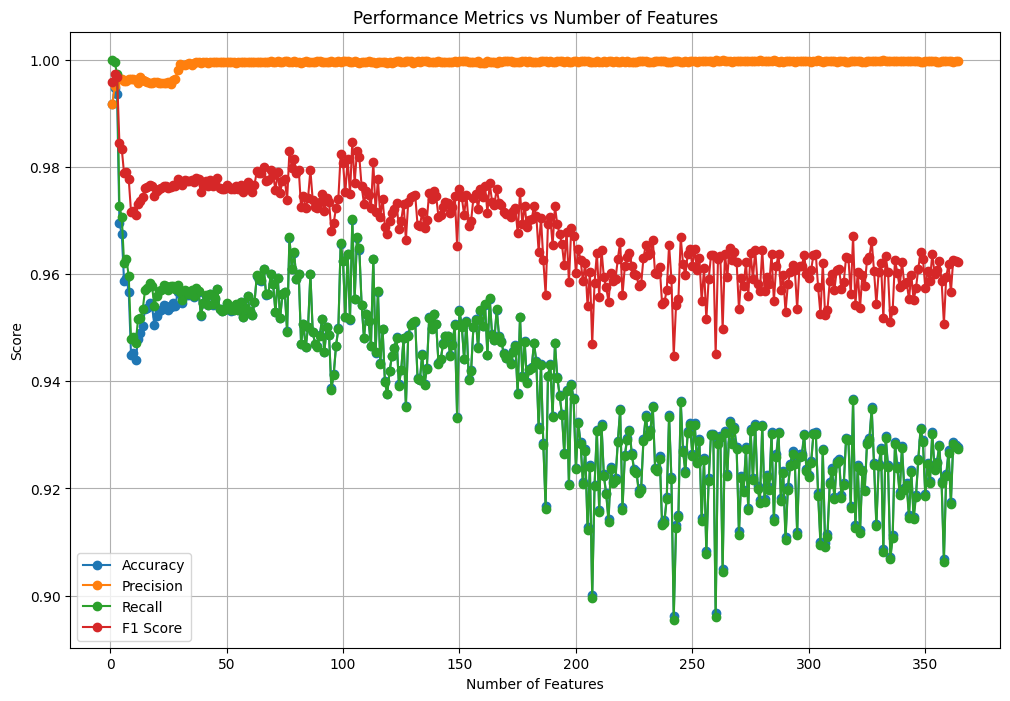

In [7]:

metrics = []
confusion_matrixs = []

for n_features in range(1, X.shape[1] + 1):
    # Select top 'n_features' features based on MI scores
    selected_features = mi_scores_series.head(n_features).index
    X_selected = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create and compile the autoencoder
    autoencoder = create_autoencoder(input_dim=n_features)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    autoencoder.summary()

    # Fit the model
    history = autoencoder.fit(X_train, X_train,
                              batch_size=64, epochs=1, verbose=0, validation_split=0.15,
                              callbacks=[TqdmCallback(), EarlyStopping(patience=3)])


# Predict reconstruction errors for the training set
    reconstructions = autoencoder.predict(X_train)
    train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
    threshold = np.mean(train_loss) + np.std(train_loss)

# Predict reconstruction errors for the test set
    reconstructions = autoencoder.predict(X_test)
    test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
    preds = predict(autoencoder, X_test, threshold)
    # Print and store performance metrics
    print(f"Number of Features: {n_features}")
    accuracy, precision, recall, f1 = print_stats(preds, y_test)
    # Rename the variable to avoid conflict
    conf_matrix = confusion_matrix(y_test, preds)
    confusion_matrixs.append({
        "n_feature": confusion_matrix,
        "conf": conf_matrix
    })
    print(conf_matrix)

    # Append metrics
    metrics.append({
        "n_features": n_features,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })

# Convert metrics to DataFrame and save to CSV
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"feature_selection_metrics.csv", index=False)

# Plot metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_df["n_features"], metrics_df["accuracy"], marker='o', label="Accuracy")
plt.plot(metrics_df["n_features"], metrics_df["precision"], marker='o', label="Precision")
plt.plot(metrics_df["n_features"], metrics_df["recall"], marker='o', label="Recall")
plt.plot(metrics_df["n_features"], metrics_df["f1_score"], marker='o', label="F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance Metrics vs Number of Features")
plt.legend()
plt.grid(True)
plt.savefig(f"metrics_vs_features.png")
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("feature_selection_metrics.csv", index=False)


filtered_metrics_df = metrics_df[metrics_df["n_features"].between(50, 100)]

plt.figure(figsize=(12, 8))
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["accuracy"],
    marker="o",
    label="Accuracy",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["precision"],
    marker="o",
    label="Precision",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["recall"],
    marker="o",
    label="Recall",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["f1_score"],
    marker="o",
    label="F1 Score",
)
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance Metrics vs Number of Features (1 to 50)")
plt.legend()
plt.grid(True)
plt.savefig("metrics_vs_features_1_to_50.png")
plt.show()

NameError: name 'metrics' is not defined

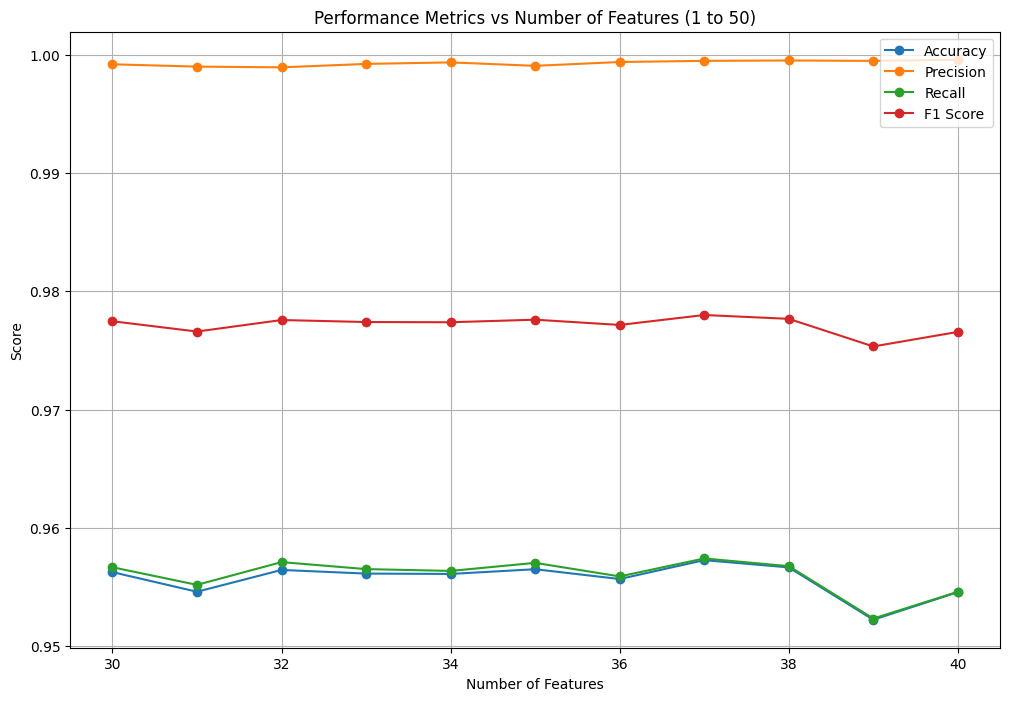

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert metrics to DataFrame and save to CSV
metrics_df = pd.read_csv("feature_selection_metrics.csv")

# Filter metrics for n_features from 1 to 50
filtered_metrics_df = metrics_df[metrics_df["n_features"].between(30, 40)]

# Plot metrics for the filtered range
plt.figure(figsize=(12, 8))
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["accuracy"],
    marker="o",
    label="Accuracy",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["precision"],
    marker="o",
    label="Precision",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["recall"],
    marker="o",
    label="Recall",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["f1_score"],
    marker="o",
    label="F1 Score",
)
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance Metrics vs Number of Features (1 to 50)")
plt.legend()
plt.grid(True)
plt.savefig("metrics_vs_features_1_to_50.png")
plt.show()

In [12]:
for idx, item in enumerate(confusion_matrixs, start=1):
    print(f"Số thứ tự: {idx}")
    print("Confusion Matrix:")
    print(item["conf"])
    print("\n")  # Add a newline for better readability

Số thứ tự: 1
Confusion Matrix:
[[    2   266]
 [    0 32281]]


Số thứ tự: 2
Confusion Matrix:
[[  108   160]
 [   14 32267]]


Số thứ tự: 3
Confusion Matrix:
[[  144   124]
 [   87 32194]]


Số thứ tự: 4
Confusion Matrix:
[[  159   109]
 [  883 31398]]


Số thứ tự: 5
Confusion Matrix:
[[  154   114]
 [  945 31336]]


Số thứ tự: 6
Confusion Matrix:
[[  144   124]
 [ 1222 31059]]


Số thứ tự: 7
Confusion Matrix:
[[  145   123]
 [ 1202 31079]]


Số thứ tự: 8
Confusion Matrix:
[[  159   109]
 [ 1303 30978]]


Số thứ tự: 9
Confusion Matrix:
[[  160   108]
 [ 1685 30596]]


Số thứ tự: 10
Confusion Matrix:
[[  160   108]
 [ 1671 30610]]


Số thứ tự: 11
Confusion Matrix:
[[  151   117]
 [ 1708 30573]]


Số thứ tự: 12
Confusion Matrix:
[[  135   133]
 [ 1561 30720]]


Số thứ tự: 13
Confusion Matrix:
[[  168   100]
 [ 1558 30723]]


Số thứ tự: 14
Confusion Matrix:
[[  152   116]
 [ 1504 30777]]


Số thứ tự: 15
Confusion Matrix:
[[  145   123]
 [ 1388 30893]]


Số thứ tự: 16
Confusion Matrix:
[[

In [12]:
print(mi_scores_series)

393    0.066482
237    0.059828
222    0.055082
232    0.051494
383    0.051379
         ...   
158    0.000170
151    0.000048
155    0.000000
244    0.000000
249    0.000000
Length: 364, dtype: float64


In [59]:
selected_features = mi_scores_series.head(200).index
data_selected= data[selected_features]
data_selected["Label"] = y

C:\Users\admin\AppData\Local\Temp\ipykernel_25084\3931722837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected["Label"] = y


In [60]:
print(list(data_selected.columns))

inx = 1
for column in data_selected.columns:
    if int(column) > 394:
        print(column)

['393', '237', '222', '232', '383', '382', '147', '212', '142', '342', '227', '22', '62', '267', '47', '217', '343', '302', '152', '312', '337', '122', '52', '132', '365', '101', '81', '86', '106', '80', '105', '172', '100', '111', '117', '131', '366', '85', '130', '187', '110', '136', '126', '96', '57', '121', '125', '42', '153', '135', '120', '327', '0', '95', '137', '116', '141', '91', '79', '192', '140', '379', '322', '4', '115', '1', '12', '184', '74', '32', '99', '127', '37', '171', '76', '375', '297', '336', '186', '300', '369', '226', '262', '207', '143', '335', '90', '225', '92', '5', '170', '301', '231', '376', '332', '179', '374', '27', '370', '230', '364', '89', '307', '331', '188', '182', '104', '75', '84', '43', '197', '202', '330', '17', '296', '31', '371', '303', '199', '53', '191', '63', '193', '306', '295', '268', '338', '269', '48', '204', '228', '148', '114', '292', '23', '38', '33', '213', '123', '24', '264', '190', '133', '233', '206', '263', '185', '46', '138', '

ValueError: invalid literal for int() with base 10: 'Label'

In [33]:
data_selected.head(10)
data_selected.to_csv("data_selected_37.csv")